In [79]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler


## Import Data


In [80]:
local_path = "insurance.csv"
data = pd.read_csv(local_path)

In [81]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [82]:
data.drop(columns=["bmi","charges"]).values

array([[19, 'female', 0, 'yes', 'southwest'],
       [18, 'male', 1, 'no', 'southeast'],
       [28, 'male', 3, 'no', 'southeast'],
       ...,
       [18, 'female', 0, 'no', 'southeast'],
       [21, 'female', 0, 'no', 'southwest'],
       [61, 'female', 0, 'yes', 'northwest']], dtype=object)

In [83]:
data_np = data.values
y = data_np[:,(2,-1)]
X = data.drop(columns=["bmi","charges"]).values

In [84]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=True)

In [39]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

X_train_enc_col, X_test_enc_col = prepare_inputs(X_train[:,(1,3,4)], X_test[:,(1,3,4)])

In [40]:
X_train[:,(1,3,4)] = X_train_enc_col

X_test[:,(1,3,4)] = X_test_enc_col



In [41]:
X_train[:,0].max()

64

In [42]:
def minmax(X) :
    
    return (X - X.min())/(X.max()-X.min())


In [43]:

X_train[:,0] = minmax(X_train[:,0])
X_test[:,0] = minmax(X_test[:,0])

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(802, 5)
(802, 2)
(536, 5)
(536, 2)


In [45]:
X_train.astype('float32')

array([[0.47826087, 0.        , 1.        , 0.        , 1.        ],
       [0.32608697, 0.        , 0.        , 1.        , 1.        ],
       [0.13043478, 1.        , 2.        , 0.        , 1.        ],
       ...,
       [0.02173913, 1.        , 0.        , 0.        , 3.        ],
       [0.95652175, 1.        , 0.        , 1.        , 0.        ],
       [0.4347826 , 0.        , 2.        , 0.        , 3.        ]],
      dtype=float32)

In [46]:
X_train = tf.convert_to_tensor(X_train.astype('float32'))
y_train = tf.convert_to_tensor(y_train.astype('float32'))
X_test = tf.convert_to_tensor(X_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('float32'))


## Create a sampling layer


In [47]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Parametrization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon 

## Build the encoder


In [48]:
latent_dim = 3 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
Leaky_ReLu = keras.layers.LeakyReLU(alpha=0.01)

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(2, activation=Leaky_ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 2)            12          ['input_3[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 3)            9           ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 3)            9           ['dense_3[0][0]']                
                                                                                            

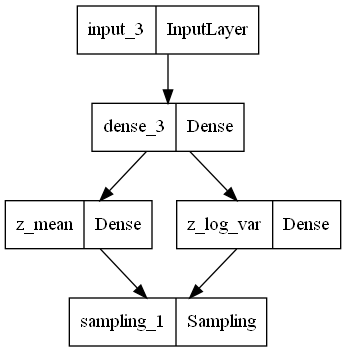

In [49]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [50]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3,  activation=Leaky_ReLu)(latent_inputs)
decoder_outputs = layers.Dense(2, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


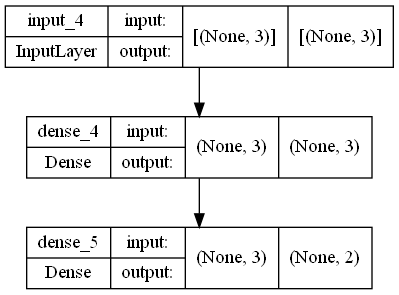

In [51]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [52]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KL_hyperparam, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.KL_hyperparam = KL_hyperparam
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [53]:
vae = VAE(encoder, decoder, 1)

In [54]:
from keras.optimizers import adam_v2
adam = adam_v2.Adam()




In [55]:
vae.compile(optimizer=adam)

In [56]:
history = vae.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=8 )

Epoch 1/200
101/101 [==============================] - 1s 3ms/step - loss: 149052172.8627 - MSE: 153771328.0000 - kl_loss: 4.0229 - val_loss_val: 172613120.0000 - val_MSE_val: 172613120.0000 - val_kl_loss_val: 4.2042
Epoch 2/200
101/101 [==============================] - 0s 2ms/step - loss: 149985326.5098 - MSE: 153761328.0000 - kl_loss: 4.1412 - val_loss_val: 172598976.0000 - val_MSE_val: 172598976.0000 - val_kl_loss_val: 4.7066
Epoch 3/200
101/101 [==============================] - 0s 2ms/step - loss: 149368773.0392 - MSE: 153731088.0000 - kl_loss: 5.5508 - val_loss_val: 172542352.0000 - val_MSE_val: 172542336.0000 - val_kl_loss_val: 8.1565
Epoch 4/200
101/101 [==============================] - 0s 2ms/step - loss: 159072819.1373 - MSE: 153653680.0000 - kl_loss: 13.0062 - val_loss_val: 172429536.0000 - val_MSE_val: 172429520.0000 - val_kl_loss_val: 20.8744
Epoch 5/200
101/101 [==============================] - 0s 2ms/step - loss: 174476208.3137 - MSE: 153519200.0000 - kl_loss: 32.4344

Epoch 38/200
101/101 [==============================] - 0s 3ms/step - loss: 63401855.3137 - MSE: 63101556.0000 - kl_loss: 44324.9023 - val_loss_val: 68116944.0000 - val_MSE_val: 68071896.0000 - val_kl_loss_val: 45047.9961
Epoch 39/200
101/101 [==============================] - 0s 3ms/step - loss: 73901242.8627 - MSE: 62817848.0000 - kl_loss: 44107.9062 - val_loss_val: 67523824.0000 - val_MSE_val: 67478928.0000 - val_kl_loss_val: 44906.6250
Epoch 40/200
101/101 [==============================] - 0s 3ms/step - loss: 55128089.3922 - MSE: 62410332.0000 - kl_loss: 43366.0430 - val_loss_val: 67071128.0000 - val_MSE_val: 67026324.0000 - val_kl_loss_val: 44816.3945
Epoch 41/200
101/101 [==============================] - 0s 3ms/step - loss: 64055626.8529 - MSE: 62047664.0000 - kl_loss: 43625.3906 - val_loss_val: 66680420.0000 - val_MSE_val: 66635668.0000 - val_kl_loss_val: 44745.2148
Epoch 42/200
101/101 [==============================] - 0s 3ms/step - loss: 62040885.4510 - MSE: 61870160.0000 -

Epoch 75/200
101/101 [==============================] - 0s 2ms/step - loss: 52634905.4902 - MSE: 49876588.0000 - kl_loss: 37483.5508 - val_loss_val: 52814084.0000 - val_MSE_val: 52775404.0000 - val_kl_loss_val: 38683.6758
Epoch 76/200
101/101 [==============================] - 0s 2ms/step - loss: 48502291.2157 - MSE: 49531532.0000 - kl_loss: 37030.2383 - val_loss_val: 52350640.0000 - val_MSE_val: 52312232.0000 - val_kl_loss_val: 38412.5820
Epoch 77/200
101/101 [==============================] - 0s 3ms/step - loss: 46033849.0196 - MSE: 49066428.0000 - kl_loss: 37286.9805 - val_loss_val: 51838492.0000 - val_MSE_val: 51800264.0000 - val_kl_loss_val: 38243.5430
Epoch 78/200
101/101 [==============================] - 0s 2ms/step - loss: 48794132.8627 - MSE: 48706636.0000 - kl_loss: 36729.9961 - val_loss_val: 51437636.0000 - val_MSE_val: 51399724.0000 - val_kl_loss_val: 37922.4570
Epoch 79/200
101/101 [==============================] - 0s 3ms/step - loss: 49761996.5098 - MSE: 48237392.0000 -

Epoch 112/200
101/101 [==============================] - 0s 2ms/step - loss: 32108968.7255 - MSE: 33039652.0000 - kl_loss: 26699.3516 - val_loss_val: 34397464.0000 - val_MSE_val: 34369036.0000 - val_kl_loss_val: 28427.9590
Epoch 113/200
101/101 [==============================] - 0s 2ms/step - loss: 36846365.5882 - MSE: 32590774.0000 - kl_loss: 26598.4609 - val_loss_val: 33883664.0000 - val_MSE_val: 33855500.0000 - val_kl_loss_val: 28169.8828
Epoch 114/200
101/101 [==============================] - 0s 2ms/step - loss: 30779864.8333 - MSE: 32098786.0000 - kl_loss: 26195.5488 - val_loss_val: 33347908.0000 - val_MSE_val: 33319970.0000 - val_kl_loss_val: 27930.4160
Epoch 115/200
101/101 [==============================] - 0s 2ms/step - loss: 31495445.0294 - MSE: 31650242.0000 - kl_loss: 25928.8027 - val_loss_val: 32876556.0000 - val_MSE_val: 32848900.0000 - val_kl_loss_val: 27657.4473
Epoch 116/200
101/101 [==============================] - 0s 2ms/step - loss: 31534913.2941 - MSE: 31177698.0

Epoch 149/200
101/101 [==============================] - 0s 2ms/step - loss: 22961225.2549 - MSE: 21800324.0000 - kl_loss: 19863.2988 - val_loss_val: 22823420.0000 - val_MSE_val: 22801412.0000 - val_kl_loss_val: 22006.8926
Epoch 150/200
101/101 [==============================] - 0s 2ms/step - loss: 22558462.3922 - MSE: 21695800.0000 - kl_loss: 19967.4258 - val_loss_val: 22718640.0000 - val_MSE_val: 22696734.0000 - val_kl_loss_val: 21894.7734
Epoch 151/200
101/101 [==============================] - 0s 3ms/step - loss: 21006292.9216 - MSE: 21602746.0000 - kl_loss: 19705.1602 - val_loss_val: 22621102.0000 - val_MSE_val: 22599248.0000 - val_kl_loss_val: 21851.4609
Epoch 152/200
101/101 [==============================] - 0s 3ms/step - loss: 17962011.1176 - MSE: 21557790.0000 - kl_loss: 19483.8555 - val_loss_val: 22547006.0000 - val_MSE_val: 22525218.0000 - val_kl_loss_val: 21786.8418
Epoch 153/200
101/101 [==============================] - 0s 2ms/step - loss: 22059836.6765 - MSE: 21448372.0

Epoch 186/200
101/101 [==============================] - 0s 2ms/step - loss: 20694825.2157 - MSE: 20428102.0000 - kl_loss: 18898.0293 - val_loss_val: 21233278.0000 - val_MSE_val: 21212450.0000 - val_kl_loss_val: 20827.9512
Epoch 187/200
101/101 [==============================] - 0s 2ms/step - loss: 19161856.7451 - MSE: 20424586.0000 - kl_loss: 18535.2520 - val_loss_val: 21226494.0000 - val_MSE_val: 21205680.0000 - val_kl_loss_val: 20810.2969
Epoch 188/200
101/101 [==============================] - 0s 3ms/step - loss: 20574067.9314 - MSE: 20427752.0000 - kl_loss: 18712.5293 - val_loss_val: 21210858.0000 - val_MSE_val: 21190040.0000 - val_kl_loss_val: 20814.1699
Epoch 189/200
101/101 [==============================] - 0s 3ms/step - loss: 20052309.7941 - MSE: 20401388.0000 - kl_loss: 18804.2891 - val_loss_val: 21189598.0000 - val_MSE_val: 21168782.0000 - val_kl_loss_val: 20812.7285
Epoch 190/200
101/101 [==============================] - 0s 2ms/step - loss: 19084094.3039 - MSE: 20400872.0

In [57]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


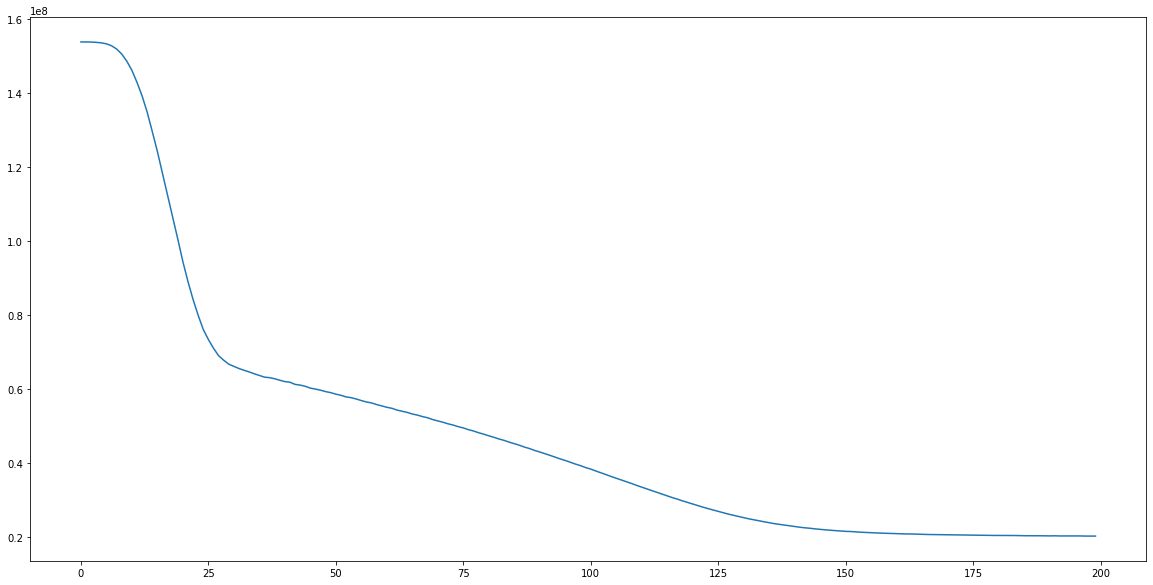

In [58]:
plt.plot(history.history['MSE'])


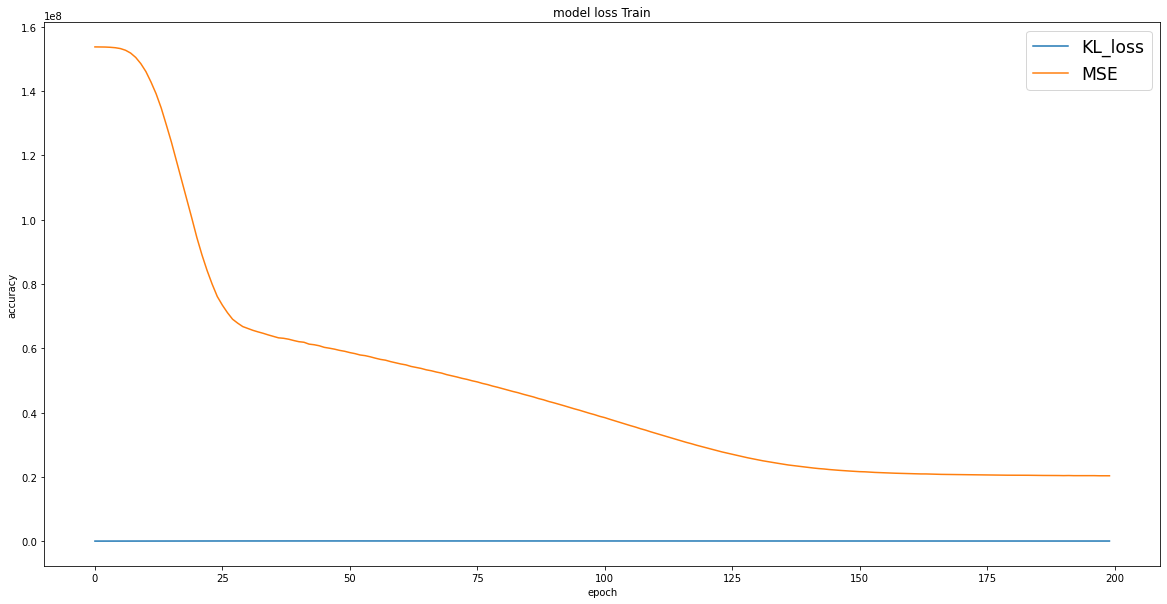

In [59]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss Train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


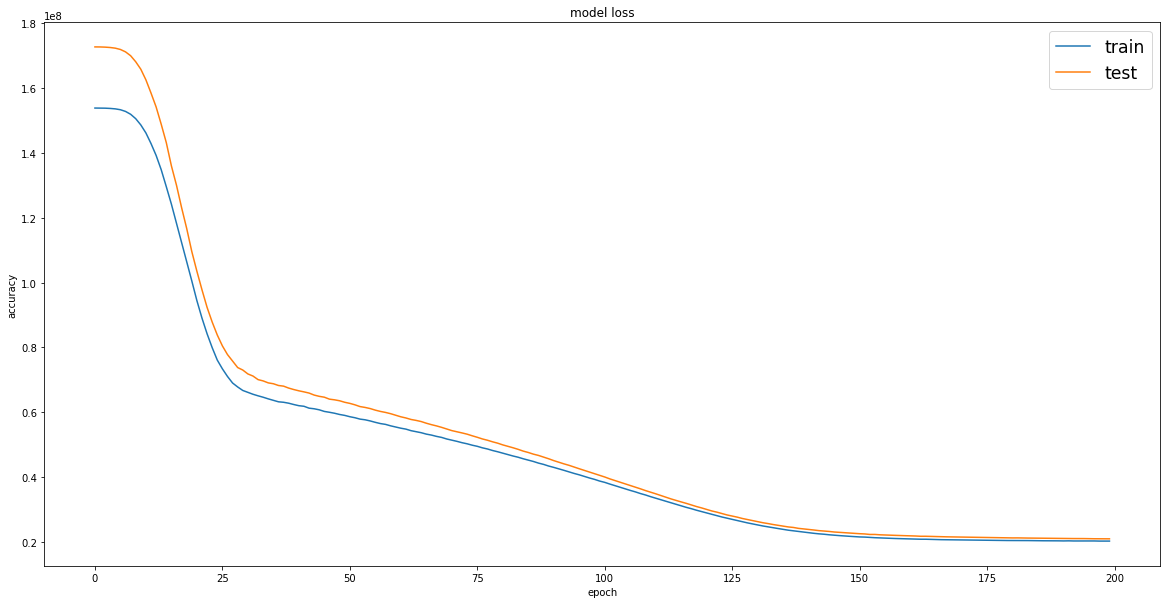

In [60]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper right', fontsize ='xx-large')
plt.show()


In [31]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 0.1308959
MAE 1132891.2
RMSE 108029.9620660861
MSE 11645598000.0


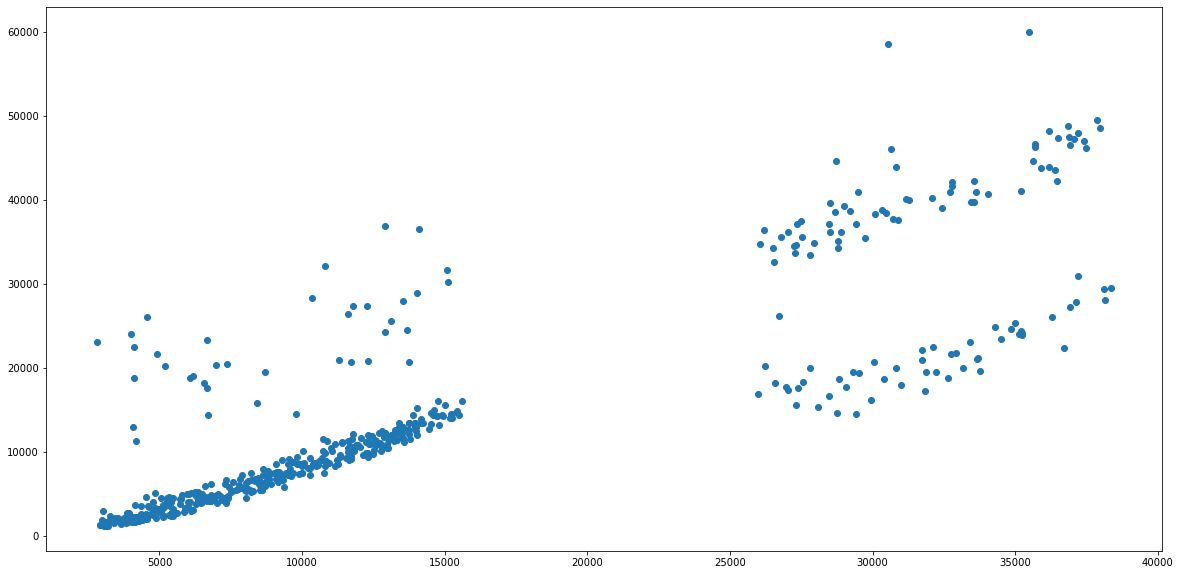

In [62]:
plt.scatter(vae.predict(X_test)[:,1], y_test[:,1])

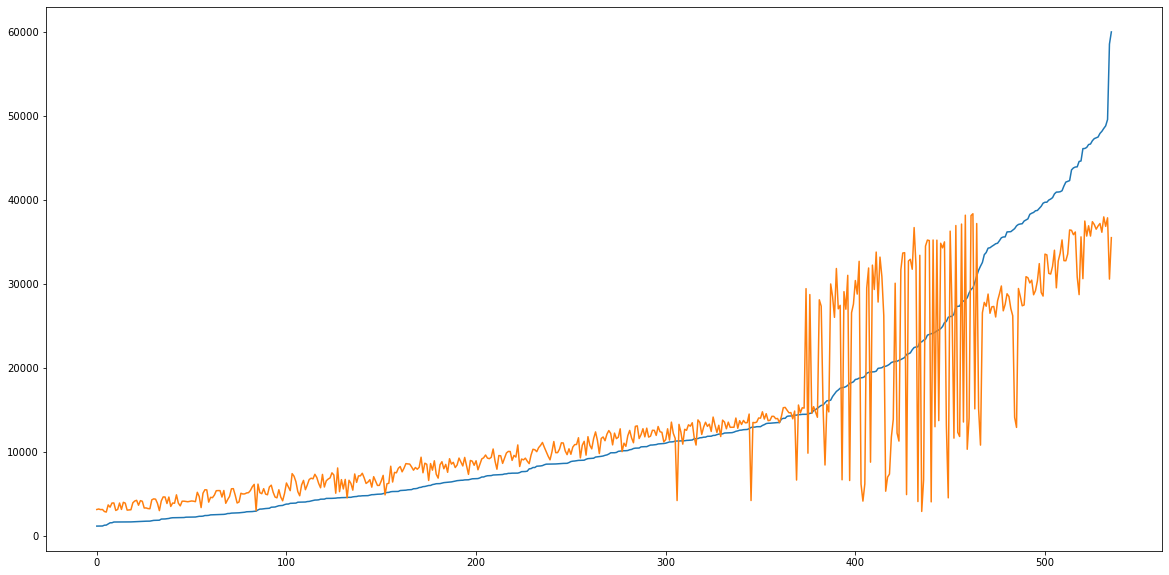

In [78]:
plt.plot(np.sort(y_test[:,1].numpy()))

plt.plot(vae.predict(X_test)[:,1][np.argsort(y_test[:,1].numpy())])

array([529, 120, 452,  18, 321, 351, 496, 442, 358, 340, 171, 325, 303,
       213, 315, 512,  39,  23, 297,  85, 436,  61,  11, 504, 141, 441,
        22,  73, 245, 202, 155, 135,  78, 143, 310, 534,  38, 187, 110,
        74, 103, 323, 498, 348, 278, 175, 402,   3, 296, 341, 154, 114,
       334, 528, 472, 129,  89, 488, 142, 473, 170,   2, 244, 386, 513,
       459,  59, 254, 299,  99, 267, 316,  20, 215,  43, 230, 370, 382,
       206, 259, 494, 418, 490, 185,  36, 105, 179, 125, 366, 268, 434,
        12, 247, 378, 482, 381,  93,  76,  65, 311, 124, 275, 520, 128,
       347,  30, 248, 502, 293, 130, 432, 399, 415, 511,  75, 271, 309,
       425, 406, 376, 373, 317, 507,  95, 115, 148,  28, 447, 450, 474,
       261, 439, 285, 387, 165, 384, 225,  53, 364,  40, 180, 345, 113,
       483, 258, 199, 371, 367, 193,  44, 468, 273, 360, 467,  47, 211,
       236,  72, 458, 265, 521, 192, 177, 219, 339,  37,  68,  35, 518,
       195, 359, 203, 283, 147, 164, 453, 408, 476, 222, 486,  1